In [4]:
# Step 1: Setup Kaggle credentials and download dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d salader/dogs-vs-cats
!unzip -q dogs-vs-cats.zip -d /content/

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown


In [5]:
# Step 2: Import libraries
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# Step 3: Load train and test data
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/train',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

val_ds = keras.utils.image_dataset_from_directory(
    directory='/content/test',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [7]:
# Step 4: Normalize pixel values (from 0–255 to 0–1)
# This speeds up training and helps the model learn better
def process(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [8]:
# Step 5: Add data augmentation to increase variety in training images
# Helps the model generalize better by simulating real-world variations
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
# Step 6: Build model using Transfer Learning
# MobileNetV2 is a lightweight CNN trained on 1.4M images (ImageNet)
# We reuse its learned features to classify cats vs dogs (transfer learning)
base_model = keras.applications.MobileNetV2(input_shape=(256, 256, 3),
                                            include_top=False,  # Remove its original classification layer
                                            weights='imagenet')  # Use pre-trained weights
base_model.trainable = False  # Freeze the pretrained layers

model = Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),  # Reduces output size without adding too many parameters
    Dense(128, activation='relu'),          # ReLU = max(0, x), adds non-linearity and avoids vanishing gradient
    Dropout(0.3),                           # Prevents overfitting by randomly dropping neurons
    Dense(1, activation='sigmoid')          # Sigmoid gives output between 0 and 1, perfect for binary classification
])

<ipython-input-9-afa2c60cc7b2>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(input_shape=(256, 256, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
# Compile the model
# - Adam: optimizer that adjusts learning rates adaptively (fast and efficient)
# - Binary crossentropy: used for two-class problems (like cat vs dog)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
# Step 7: Setup callbacks
# - EarlyStopping stops training if val_accuracy doesn't improve for 3 epochs
# - ModelCheckpoint saves the best model automatically
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)

In [14]:
# Step 8: Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 311s 497ms/step - accuracy: 0.9780 - loss: 0.0556 - val_accuracy: 0.9852 - val_loss: 0.0374
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 299s 478ms/step - accuracy: 0.9815 - loss: 0.0491 - val_accuracy: 0.9856 - val_loss: 0.0391
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 324s 481ms/step - accuracy: 0.9805 - loss: 0.0491 - val_accuracy: 0.9854 - val_loss: 0.0433
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 307s 491ms/step - accuracy: 0.9821 - loss: 0.0469 - val_accuracy: 0.9864 - val_loss: 0.0393


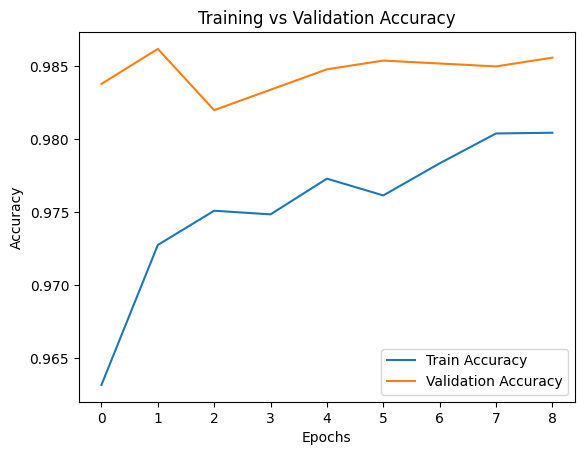

In [13]:
# Step 9: Plot accuracy curve to visualize model learning
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━

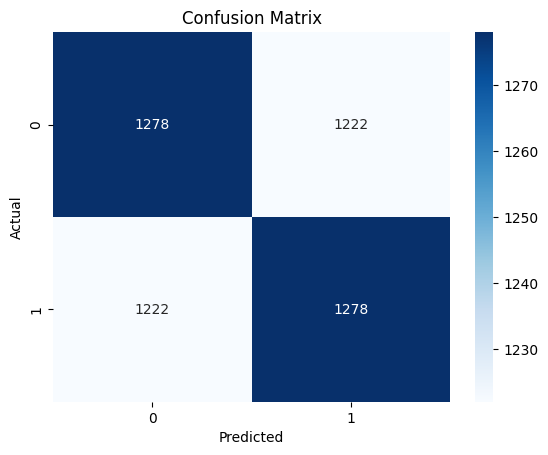

In [15]:
# Step 10: Evaluate model on test set using confusion matrix and classification report
y_true = np.concatenate([y for x, y in val_ds])
y_pred = np.concatenate([model.predict(x).round() for x, _ in val_ds])

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [16]:
# Shows precision, recall, F1-score
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

              precision    recall  f1-score   support

         Cat       0.51      0.51      0.51      2500
         Dog       0.51      0.51      0.51      2500

    accuracy                           0.51      5000
   macro avg       0.51      0.51      0.51      5000
weighted avg       0.51      0.51      0.51      5000

